# FRUIT CLASSIFICATION
## DEVELOPED BY WALTER MAFFIONE <br>
At the moment of this work (05-2019) this dataset contains 103 class of different fruits and 53177 total images.
My idea is to perform different classification algorithms, in particular SVM, K-NN, Decision Tree, firstly for a binary classification task, then for a multi-class one. 
I'll also apply Principal Component Analysis in order to reduce the dimensionality of the dataset, see the variance of each class and then I'll try to apply classification algorithm having only two dimension. 
At the end I'll make a comparison between all methods in order to find which of them perform better on this dataset.

In the future I'd like to implement a CNN, out of the purpose of this work, that almost surely will be a solution better than others in terms of accuracy, but for the moment I limit myself to the mentioned algorithms.

In [1]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

print(os.listdir("../input"))
dim = 100

['fruits-360_dataset', 'fruits-360-original-size']


In [2]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "../input/*/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "../input/*/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("../input/*/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits
    

## CHOOSE YOUR CLASS
I've implemented two function in order to choose the fruit you want, for binary classification I've decided to take **Cocos** and **Pineapple** cause they look similar and so the classification task will be not too easy.

In [3]:
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos'] #Binary classification

#Get Images and Labels 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

#Get data for k-fold
X,y = getYourFruits(fruits, '', print_n=True, k_fold=True)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

There are  490   TRAINING  images of  PINEAPPLE
There are  490   TRAINING  images of  COCOS
There are  166   TEST  images of  PINEAPPLE
There are  166   TEST  images of  COCOS


Each image is converted in a 100x100 numpy array for each RGB dimension (x3). Then has been flatted in one single vector (Image Features Vector) and then scaled subtracting the mean of the dataset in order to perform classification algorithms.

In the image below the last matrix is our **X_train**, with a shape of 30000x980

![](https://i.imgur.com/lC1pcrV.jpg)

# VISUALIZATION OF DATA
Let's see now how one of our samples appears

In [4]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1        

Pineapple


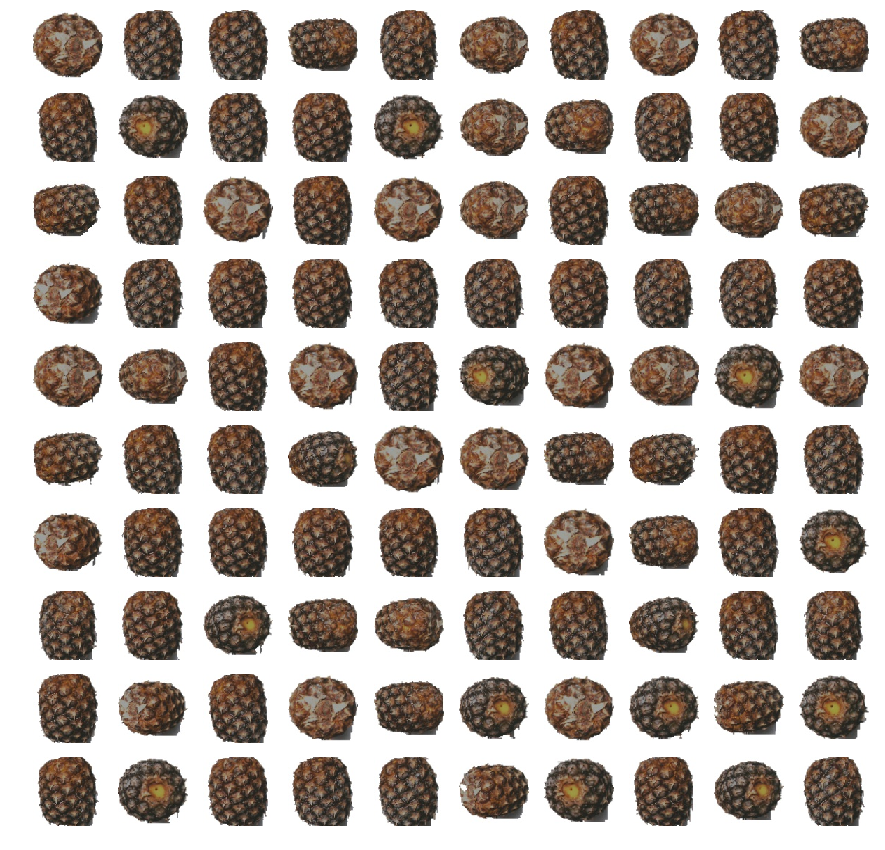

In [5]:
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

Cocos


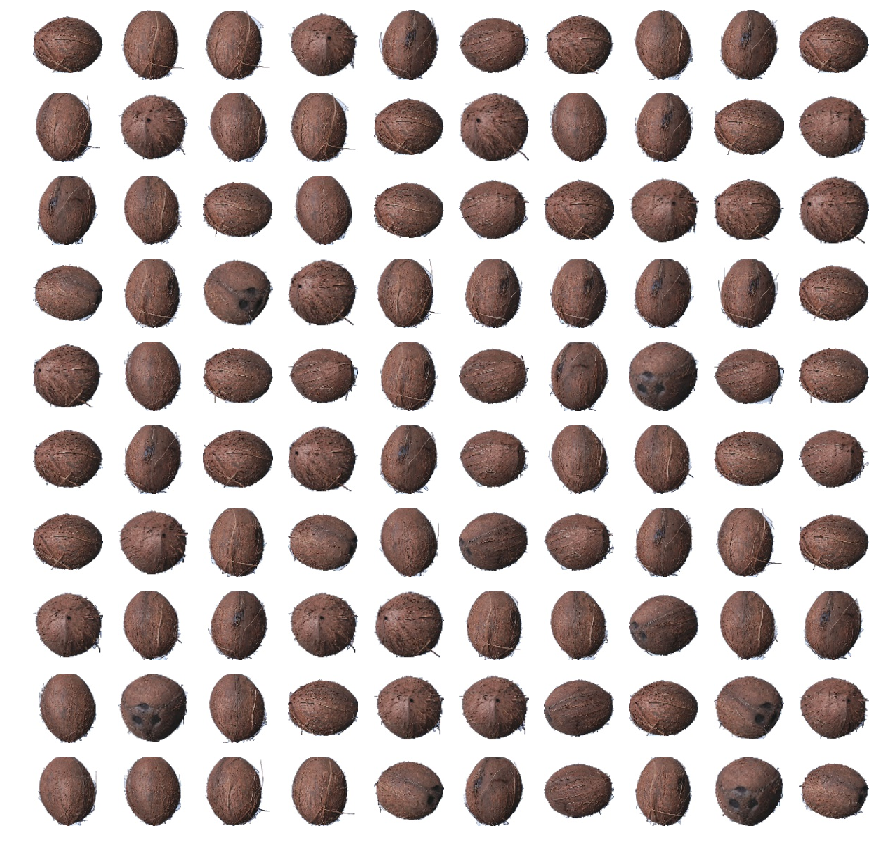

In [6]:
print(fruits[y_train[490]])
plot_image_grid(X_t[490:590], 10, 10)

In [7]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=fruits, yticklabels=fruits,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

## DATA IN LOWER DIMENSIONS
In order to discover how our data appears in lower dimension we need to reduce dimensionality of the dataset in 2 or 3 dimension so that we can plot and visualize them. To do this I've decided to use Principal Component Analysis, explained in the next chapter, but a better solution could be use t-SNE (T-distributed Stochastic Neighbor Embedding) or MDS (Multi Dimensional Scaling), nonlinear dimensionality reduction techniques well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.<br> 
No assumption about linearity of the dataset could be make considering those graphs.

### DATA IN 2D

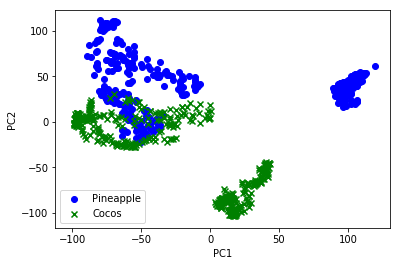

In [8]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

### DATA IN 3D

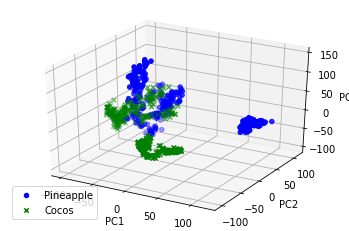

In [9]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

# PRINCIPAL COMPONENT ANALYSIS
Principal Component Analysis is a technique used in order to reduce the dimensionality of a dataset while preserving as mush information as possible. Data is reprojected in a lower dimensional space, in particular we need to find a projection that minimizes the squared error in reconstructing the original data. <br>

![Principal Component Analysis](https://sebastianraschka.com/images/faq/lda-vs-pca/pca.png)

<br>
There are 3 different technique in order to apply PCA:
1. **Sequential**  
2. **Sample Covariance Matrix**
3. **Singular Value Decomposition (SVD)** <br>

I'll explain the Sample Covariance Matrix technique:
* The first thing to do is to standardize the data, so for each sample we need to substract the mean of the full dataset and then divide it by the variance, so as having an unitary variance for each istance. This last process is not completly necessary but it is usefull to let the CPU work less.
$$
    Z = \frac{X-\mu}{\sigma^2} 
$$
<br>
* Then we need to compute Covariance Matrix, given data { $x_1 ,x_2, ..., x_n$ } with $n$ number of samples, covariance matrix is obtained by:<br><br>
$$
\Sigma = \frac {1}{n}\sum_{i=1}^n (x_i - \bar{x})(x - \bar{x})^T $$    $\;\;$  where  $$\bar{x} = \frac {1}{n}\sum_{i=i}^n x_i $$ <br>
Or simply by multiplying the standardized matrix Z by it self transposed<br>
$$ COV(X) = Z Z^T $$<br>

* Principal Components will be the eigenvectors of the Covariance Matrix sorted in order of importance by the respective eigenvalues.<br>**Larger eigenvalues $\Rightarrow$ more important eigenvectors.**<br> They represent the most of the useful information on the entire dataset in a single vector

In [10]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id])
    return newImage

def showVariance(X_train):
    #Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    #eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(10):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(10)    
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()

    plt.show()

## PCA EXAMPLE

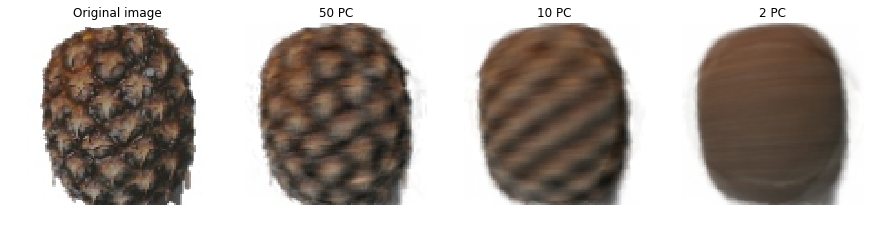

In [11]:
image_id = 2
image = X_t[image_id]

#Compute PCA
X_2 = computePCA(2, X_train,image_id)
X_10 = computePCA(10, X_train,image_id)
X_50 = computePCA(50, X_train,image_id)

#Reshape in order to plot images
X2 = np.reshape(X_2, (dim,dim,3)).astype(int)
X10 = np.reshape(X_10, (dim,dim,3)).astype(int)
X50 = np.reshape(X_50, (dim,dim,3)).astype(int)

#Plot
showPCA(image, X2, X10, X50)

#### COMMENT
From those images is possible to understand how considering only a sample and obtaining its principal components from the whole dataset, it's possible for **us** to classify easly the fruit just considering a low number dimension instead of all. This means a lot of data less.<br>
Obviously for a classification algorithm accuracy of the classification will be lower but instead training time will be faster, if the classes were linearly separable the accuracy could be satisfactory.

## VARIANCE EXPLAINED USING PC

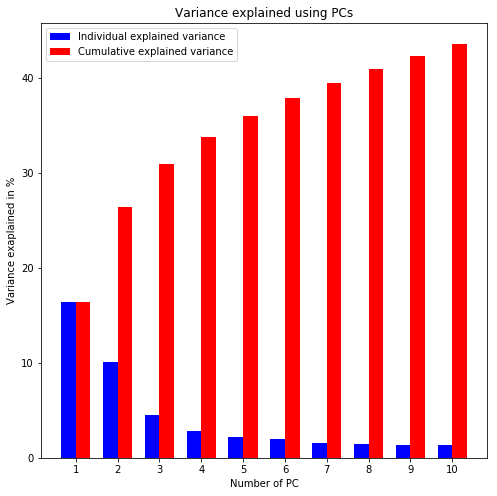

In [12]:
showVariance(X_train)

#### COMMENT

As we can see from this graph the first PC captures only 16-17% of variance, using first two the percentage of information captured is less than **30%**. 

In the next section I'll perform also classification using only first two dimension, this is not to get a good accuracy, because with so low information classifiers will not be able to learn so much, but instead is made in order to show **decision boundaries** of classifiers when using two dimensions. 


Using first 10PC, variance captured is **40%**, not a bad results considering that the dataset has hundreds of dimension.




# BINARY CLASSIFICATION
Let's start now to classify our dataset, firstly we take only two class in order to perform a classic binary classification, at the end the entire dataset (or a sub-part of it) will be classified. 
I'll use 3 different technique: **SVM**, **K-NN**, **Decision Tree**.<br>
At the end of the Binary Classification there will be a comparison between all the methods.

## K-FOLD CROSS VALIDATION

Dataset is divided yet in Training and Test set by the authors of the dataset it self.<br>
In proportion approximately **75% Training images, 25% Test images**.<br>
Models will be trained considering only Training set and then Test set will be used in order to evaluate their performance in terms of accuracy.<br>
This approach not always the best choice, because due to sample variability between training and test set, our model could gives a better prediction on training data but fail to generalize on test data; and the subset choosen could have bias and not be representative of the entire dataset.

From this problem comes the technique of **Cross-validation**.<br>Cross-validation is a statistical technique which involves **partitioning the data into subsets**, **training the data on a subset and use the other subset to evaluate the model’s performance.**
To reduce variability we perform multiple rounds of cross-validation with different subsets from the same data.
We combine the results from these multiple rounds to come up with an estimate of the model’s predictive performance.<BR>
Cross-validation will give us a more accurate estimate of a model’s performance.
    
**K-FOLD Cross Validation** in particular involves randomly dividing the dataset into k groups or folds of approximately equal size.<br> The first fold is kept for testing and the model is trained on k-1 folds.<br>
The process is repeated K times and each time different fold or a different group of data points are used for validation.<BR>
![](https://i.imgur.com/WPHsss9.png)

<br>
# SUPPORT VECTOR MACHINES
A Support Vector Machine (SVM) is a supervised classification method, that after a training
phase can identify if a new point belongs to a class or another with the highest
mathematically accuracy.
It's a binary classification method, but using an approach called One vs All is possible to use SVM for multi-class classification.

If a dataset is linearly separable it means that we could use a Hard margin approach, or rather find the two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible and so we are being able to identify to which class belongs each point of the dataset. But mostly of the time datasets are not linearly
separable and so we can take two ways, one is to continue using a Linear approach using Soft Margin, or simplifying, admitting some misclassification. While the second way is to use a Non-Linear Kernel (that must satisfy Mercer Condition) or rather a mapping of the data on a higher dimensional space, where the data is linearly separable and the classification task can be solved easly,without even need to calculate the points projections.


General solution | Optimal solution
- | - 
![](https://cdn-images-1.medium.com/max/720/0*9jEWNXTAao7phK-5.png) | ![](https://cdn-images-1.medium.com/max/720/0*0o8xIA4k3gXUDCFU.png)

<br><br>

If we want to use a Linear Soft-Margin approach the optimization task is to find a  margin that should be as big as possible and we need then to add a penalty if a point is misclassified.
This is made by adding to the optimization problem another term of Loss, regularizated by a slack variable C. This term will say how well we want to fit our data and how many mistakes we grant to do.

The Loss function used  for this problem is the Hinge Loss. <br>

$$ L(y, f(x)) = \max ( 0 , 1 - y · f(x) ) $$

![Hinge Loss Function](https://i.stack.imgur.com/Ifeze.png)

<br>
The optimization problem to solve will be: 

$$ minimize \frac{1}{2} ||{w}||^2 + C \sum_{i=1}^n \xi_i  
   \;\;\;,\;subject\;to\;\;\;y_i[x_i·w + b] \geq 1 - \xi_i $$

<br> Where $\frac{1}{||w||}$ is margin size, C our hyperparameter and $\xi_i$ the distance from the point to the boundarie line.<br>

At the end we need to find the right trade-off between margin and penalty.
So, the only parameter that we can choose is C because the optimization problem and the calculus are committed to the calculators.<br> Kernel type could be set to linear if the problem is linearly separable, otherwise a Gaussian kernel (RBF) fit well most of the time. Gamma is a kernel hyperparameter that tries to exactly fit the training data.

#### LINEAR SVM

Accuracy with SVM: 97.59%


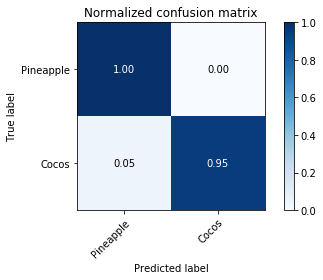

In [13]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train) 
y_pred = svm.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred,classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)


#### SVM + K-FOLD

In [14]:
pred_kfold = cross_val_score(svm, X, y, cv=5) 
print("Accuracy with SVM and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with SVM and K-FOLD CROSS VALIDATION: 1.00 (+/- 0.00)


#### LINEAR SVM + PCA

Accuracy with SVM considering only first 2PC: 13.86%


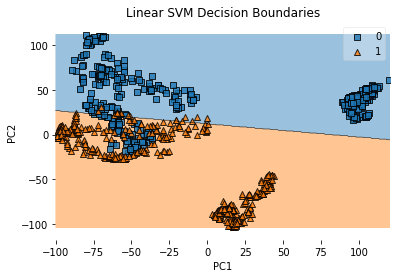

In [15]:
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

svm.fit(X_train2D, y_train) 
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Linear SVM Decision Boundaries')
plt.show()

#### KERNEL SVM + PCA

Accuracy with Not-Linear SVM considering only first 2PC: 52.11%


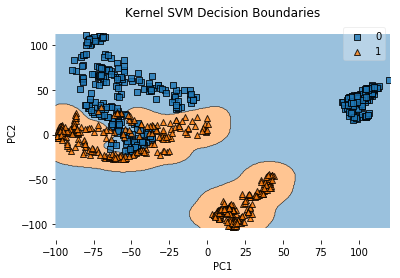

In [16]:
svm_with_kernel = SVC(gamma=0.01, kernel='rbf', probability=True)
svm_with_kernel.fit(X_train2D, y_train) 
y_pred = svm_with_kernel.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Not-Linear SVM considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=svm_with_kernel, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kernel SVM Decision Boundaries')
plt.show()

<br> 
# K-NEAREST NEIGHBOR

K-NN is a supervised learning method that considers the K closest training examples to the point of interest for predicting its class. The point is assigned to the class that is closest. <br>
Could be applied different distance metrics such as: Euclidian, Weighted, Gaussian, etc.
Steps are pretty easy:<br>

*  Receive an unclassified data

*  Measure the distance with choosen metrics from the new data to all others data that are already classified.

*  Gets the K smaller distances

*  Check the list of classes that had the shortest distance and count the amount of each class that appears

*  Takes as correct class the class that appeared the most times

*  Classifies the new data with the class that you took in previous step 
<br>

Accuracy with K-NN: 96.99%


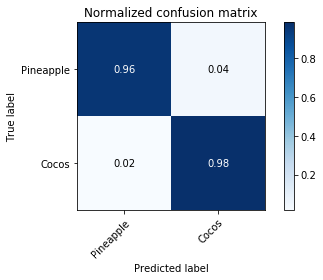

In [17]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)


In [18]:
#KNN + K-FOLD
pred_kfold = cross_val_score(knn, X, y, cv=5) 
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 1.00 (+/- 0.00)


In [ ]:
#CHANGING VALUES OF N
accuracy_train = []
accuracy_test = []

for i in range(1,15):   #check all possible values for 1 to 15
    k_nn = KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(X_train,y_train)
    pred_i = k_nn.predict(X_test)
    accuracy_train.append(k_nn.score(X_train,y_train)*100)
    accuracy_test.append(k_nn.score(X_test,y_test)*100)
    
accuracy_train_array=np.asarray(accuracy_train)
accuracy_test_array=np.asarray(accuracy_test)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,15),accuracy_train_array, label='Training_Accuracy', color='blue')
plt.plot(range(1,15),accuracy_test_array, label='Testing_Accuracy', color='red')
plt.legend()
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy%')

plt.show()

#### COMMENT

From this graph is possible to understand how the best value of K is equal to **2**, because the Test Accuracy reaches the best accuracy score and then start decreasing. 

Training accuracy still maintain 100% accuracy starting decreasing for last numbers of K 

In [ ]:
#K-NN + PCA
knn.fit(X_train2D, y_train)
y_pred = knn.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=knn, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-NN Decision Boundaries')
plt.show()

# DECISION TREE
In a decision tree each intermediate node of the tree contains splitting attributes used to build different paths, while leaves contains class labels.

There are differt algorithms to build a decision tree, all are made with a greedy approach, optimal locally.<br>The most famous is **Hunt's algoritm**. <br>

![](https://cdn-images-1.medium.com/max/880/0*QctkHiOX2G2pvfD_.jpg)

Strarting from an empty tree, we need to find iteratively best attribute on which split the data locally at each step. If a subset contains records that belongs to the same class then the leaf containing such class label is created, otherwise if a subset is empty is assigned to default to mayor class.

Critical points of decision trees are test condition, the selection of the best attribute and the splitting condition. 
For the selection of the best attribute is generally choosen the attribute that generate homogeneus nodes. 
There are different metrics in order to find the best splitting homogenity, the most common are:
* **GINI IMPURITY INDEX**: Given **$n$** classes and $p_i$ the fraction of items of class $i$ in a subset p, for $i$∈{1,2,...,n}. Then the GINI index is defined as: $$ GINI = 1 − \sum_{i=1}^n p_i^2 $$

* **INFORMATION GAIN RATIO**: The information gain is based on the decrease of entropy after a data-set is split on an attribute. Constructing a decision tree is all about finding attribute that returns the highest information gain (i.e., the most homogeneous branches).<br>Entropy is defined as $H(i) = -\sum_{i=1}^n p_i\log_2 p_i $.<br> So then Information gain is defined as: 

$$ IG = H(p) - H(p,i)  = H(p) - \sum_{i=1}^n \frac{n_i}{n} H(i) $$

where p is the parent node.
Advantages of Decision Trees are velocity, easy to interpretate and good accuracy, but they could be affected by missing values.

In [ ]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = tree.predict_proba(X_test)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, probs)
tree_auc = metrics.roc_auc_score(y_test, probs)

In [ ]:
#DECISION TREE + K-FOLD
pred_kfold = cross_val_score(tree, X, y, cv=5) 
print("Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

In [ ]:
# CHANGING MAX_DEPTH
score_train=[]
score_test=[]

for i in range(1,10):
    dtree_md = DecisionTreeClassifier(max_depth=i)
    dtree_md.fit(X_train,y_train)
    
    score_train.append(dtree_md.score(X_train,y_train)*100)
    score_test.append(dtree_md.score(X_test,y_test)*100)
    
score_train_array=np.asarray(score_train)
score_test_array=np.asarray(score_test)
plt.figure(figsize=(10,6))
plt.plot(range(1,10),score_train_array,color='blue', label="Training_accuracy")
plt.plot(range(1,10),score_test_array,color='red',label="Testing_accuracy")

plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Accuracy%')
plt.show()

Accuracy on Training phase increase while the Accuracy on Test phase is decreasing, this means that the model **overfit** increasing the max depth of the tree.

In [ ]:
#DECISION TREE + PCA
tree = tree.fit(X_train2D,y_train)
y_pred = tree.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=tree, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Tree Decision Boundaries')
plt.show()

# MODEL EVALUATION

In order to find the most suitable algorithm to this dataset, different evaluation methods will be presented: **Accuracy, Confusion Matrix, ROC Curve.**
<br>
Given: 
* TP = #samples for which the prediction is Fruit1 and the true label is Fruit1
* FP = #samples for which the prediction is Fruit2 but the true label is Fruit1
* TN = #samples for which the prediction is Fruit2 and the true label is Fruit2
* FN = #samples for which the prediction is Fruit1 but the true label is Fruit2

We can define: 

* **ACCURACY: $\frac{TP+TN}{TP+FP+TN+FN}$ that is the percentage of samples classified correctly. **

* **CONFUSION MATRIX:  A simple table with previous values used to show performance of a classifier**

* **ROC CURVE: Area Under the Receiver Operating Characteristic curve (AUC)**<br><br>
To introduce this concept, we define the following two metrics:<br>

    * **True positive rate (TPR):**   TPR = recall = $\frac{TP}{FN+TP}$<br><br>
    
    * **False positive rate (FPR):**   FPR = $\frac{FP}{TN+FP}$<br>
    
In order to plot the Receiver Operating Characteristic (ROC) curve we need to compute TPR and FPR and choose a number of thresholds for the classification (AUG). Area under the ROC curve, performed plotting TPR and FPR is used as evaluation matrics for the different classifiers.

In [ ]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(tree_fpr, tree_tpr, 'r', marker='.',label = 'DECISION TREE = %.3f' % tree_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### COMMENT:
SVM and K-NN performs better with this classification with an AUC = 0.99x, instead Decision Tree is worst with an AUC of 0.65 

# MULTI-CLASS CLASSIFICATION 

In [ ]:
fruits = ['Orange', 'Banana' , 'Strawberry', 'Apple Golden 1', 'Kiwi' , 'Lemon', 'Cocos' , 'Pineapple' , 'Peach', 'Cherry 1', 'Cherry 2', 'Mandarine']
#fruits = getAllFruits() #Be sure to have enough free memory

#Get Images and Labels
X, y =  getYourFruits(fruits, 'Training')
X_test, y_test = getYourFruits(fruits, 'Test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

In [ ]:
#SVM
model = SVC(gamma='auto', kernel='linear')
model.fit(X_train, y) 
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

#K-NN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))

#DECISION TREE
model = DecisionTreeClassifier()
model.fit(X_train,y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))

### COMMENT 
SVM is the classification algorithm that performs better in the multi-class classification task.